In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.5 MB/s eta 0:00:00


In [3]:
from transformers import AutoTokenizer
from textblob import TextBlob 


In [4]:
import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.


True

In [5]:
from nltk.corpus import stopwords
 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [7]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [8]:
from nltk.tag.stanford import StanfordNERTagger 
st = StanfordNERTagger('/content/drive/MyDrive/EEE_486/Code/stanford-ner/english.all.3class.distsim.crf.ser.gz', '/content/drive/MyDrive/EEE_486/Code/stanford-ner/stanford-ner.jar')


In [9]:
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as ic
import pandas as pd
import numpy as np


# Buranın runlanmasına gerek yok

In [47]:
basics = pd.read_csv("/content/drive/MyDrive/EEE_486/Code/single_word.csv")["CUE"]
sheet_names =  ["3 Answers", "4 Answers", "5 Answers",  "6 Answers", "7 Answers"]
all_df = pd.DataFrame([])
for sheet_namee in sheet_names:
  all_df =  pd.concat([all_df, pd.read_excel("/content/drive/MyDrive/EEE_486/Code/Family Feud Question Database (1).xlsx", sheet_name = sheet_namee).iloc[:,1:]],axis = 0)
all_df = all_df.reset_index()
all_df = all_df.drop(columns = "index")
all_answers =pd.DataFrame([])
for i in range(7):
  answer_col = pd.concat([all_df.iloc[:,i],pd.DataFrame([np.ones(len(all_df.iloc[:,i]))*(i+1)]).T],axis=1)
  answer_col.columns = ["answer","rank"]
  all_answers = pd.concat([all_answers, answer_col], axis =0)
all_answers = all_answers.dropna()
all_answers = (all_answers.reset_index()).drop(columns = "index")

In [48]:
df = all_answers[all_answers['answer'].apply(lambda x: not isinstance(x, int))]

In [66]:
df["rank"]

1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
        ... 
27338    7.0
27339    7.0
27340    7.0
27341    7.0
27342    7.0
Name: rank, Length: 15345, dtype: float64

In [50]:
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in df["answer"] if not w.lower() in stop_words]
filtered_sentence = []
 
for w in df["answer"]:
    if w in stop_words:
        df = df.drop(df[df["answer"]==w].index)


In [51]:
df.shape

(15345, 2)

In [52]:
df.to_csv("/content/drive/MyDrive/EEE_486/Code/labels.csv")

In [54]:
for kelime in basics:
  df["label"]= np.where(df['answer'].str.lower().isin(basics), 1, 0)


<ipython-input-54-cc4ab3473919>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"]= np.where(df['answer'].str.lower().isin(basics), 1, 0)


In [55]:

def init_loader( max_length=16, batch_size=32, test_size=0.2, random_state=2023):
    model_checkpoint = "bert-base-uncased"
    data =pd.read_csv("/content/drive/MyDrive/EEE_486/Code/labels.csv")
    data["answer"] = [str(i) for i in data["answer"].values]
    data = (data.reset_index()).drop(columns = "index")
    x = {}
    y = {}
    input_ids, attention_mask = {}, {}
    datasets, loader = {}, {}
    label_ids, label_attention_mask = {}, {}


    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    x = data["answer"]
  
    input = tokenizer(
        list(x),
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors="pt",
    )

    input_ids, attention_mask = input.input_ids, input.attention_mask
    
    return input_ids


In [56]:
outputs = init_loader(7, 32, 0.2)


In [57]:

feature_vec =  pd.DataFrame(np.array(outputs)[:,:,])

In [58]:
all_df = pd.concat([df["answer"],df["rank"], feature_vec, df["label"]],axis=1)

all_df = all_df.dropna()

all_df = (all_df.reset_index()).drop(columns = "index")

In [59]:
all_df

,answer,rank,0,1,2,3,4,5,6,label
0,Couch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0
2,Cane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0
4,Wrap It,1.0,101.0,2479.0,1013.0,3509.0,102.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7712,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0
7713,Eating/Drinking,3.0,101.0,2769.0,102.0,0.0,0.0,0.0,0.0,0.0
7714,Star Wars,3.0,101.0,19503.0,102.0,0.0,0.0,0.0,0.0,0.0
7715,Watching TV,3.0,101.0,2693.0,3553.0,102.0,0.0,0.0,0.0,0.0


In [60]:
for kel in all_df["answer"]:
  
  index = kel.find('/')
  if index != -1:
    all_df["answer"].iloc[all_df[all_df["answer"] == kel].index] = kel[:index]
  index = kel.find('Popcor')
  if kel.lower() == "popcor":
     all_df["answer"].iloc[all_df[all_df["answer"] == kel].index] ="popcorn"

  
for kel in all_df["answer"]:
      
  if (len(kel.split(" ")) >1):
      all_df = all_df.drop(all_df[(all_df["answer"]== kel)].index)
words = set(nltk.corpus.words.words())

for kel in all_df["answer"]:

  for w in  nltk.wordpunct_tokenize(kel.lower()):
    if w.lower() not in words and  w.isalpha():
     all_df = all_df.drop(all_df[(all_df["answer"]== kel)].index)
all_df = (all_df.reset_index()).drop(columns = "index")
all_df["answer"] = all_df["answer"].apply(lambda x: "".join(TextBlob(x).correct()))

<ipython-input-60-22039317ccdc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df["answer"].iloc[all_df[all_df["answer"] == kel].index] = kel[:index]


In [61]:
length_list = []
for kel in all_df["answer"]:
  length_list.append(len(kel))
all_df["length"] = length_list

In [63]:
all_df

,answer,rank,0,1,2,3,4,5,6,label,length
0,Touch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0,5
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0,6
2,Lane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0,4
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0,4
4,Island,1.0,101.0,3422.0,102.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...
4085,Flush,3.0,101.0,3132.0,2051.0,3749.0,102.0,0.0,0.0,1.0,5
4086,Bandy,3.0,101.0,19070.0,2075.0,102.0,0.0,0.0,0.0,1.0,5
4087,House,3.0,101.0,14415.0,9516.0,5562.0,102.0,0.0,0.0,1.0,5
4088,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0,5


In [ ]:
"""
for sent in nltk.sent_tokenize("gRİnch"):
    tokens = nltk.tokenize.word_tokenize(sent)
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1]=='PERSON': print(tag)"""

'\nfor sent in nltk.sent_tokenize("gRİnch"):\n    tokens = nltk.tokenize.word_tokenize(sent)\n    tags = st.tag(tokens)\n    for tag in tags:\n        if tag[1]==\'PERSON\': print(tag)'

In [64]:
def pos_tagg_eliminator(df):
  tag_dict = wn_postag = {"NOUN":wn.NOUN,  "ADJ":wn.ADJ, "VERB":wn.VERB, "ADV":wn.ADV, "ADJ_SAT": wn.ADJ_SAT, "PERSON":"p" }
  for word in df["answer"]:
     pos_tagged = pos_tag(word_tokenize(word), tagset='universal')
     if pos_tagged[0][1] not in tag_dict.keys():
        df = df.drop(df[df["answer"]==word].index)
        print(pos_tagged)

  df = (df.reset_index()).drop(columns = "index")
  return df
all_df = pos_tagg_eliminator(all_df)

[('At', 'ADP')]
[('Of', 'ADP')]
[('Each', 'DET')]
[('Wear', 'ADP')]
[('Your', 'PRON')]
[('By', 'ADP')]
[('Eight', 'NUM')]
[('Eight', 'NUM')]
[('of', 'ADP')]
[('At', 'ADP')]
[('All', 'DET')]
[('At', 'ADP')]
[('Rough', 'ADP')]
[('At', 'ADP')]
[('Weapon', 'ADP')]
[('All', 'DET')]
[('Some', 'DET')]
[('At', 'ADP')]
[('By', 'ADP')]
[('At', 'ADP')]
[('All', 'DET')]
[('By', 'ADP')]
[('At', 'ADP')]
[('C', 'X')]
[('At', 'ADP')]
[('At', 'ADP')]
[('Each', 'DET')]
[('All', 'DET')]
[('Some', 'DET')]
[('of', 'ADP'), ('&', 'CONJ'), ('T', 'NOUN')]
[('Laugh', 'ADP')]
[('At', 'ADP')]
[('It', 'PRON')]
[('An', 'DET')]
[('All', 'DET')]
[('All', 'DET')]
[('Up', 'ADP')]
[('At', 'ADP')]
[('At', 'ADP')]
[('Underwear', 'ADP')]
[('At', 'ADP')]
[('At', 'ADP')]
[('of', 'ADP')]
[('At', 'ADP')]
[('Underwear', 'ADP')]
[('To', 'PRT')]
[('100MPH', 'NUM')]
[('Weapon', 'ADP')]
[('All', 'DET')]
[('Eight', 'NUM')]
[('All', 'DET')]
[('At', 'ADP')]
[('An', 'DET')]
[('At', 'ADP')]
[('Each', 'DET')]
[('At', 'ADP')]
[('At', 'ADP

In [65]:
all_df

,answer,rank,0,1,2,3,4,5,6,label,length
0,Touch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0,5
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0,6
2,Lane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0,4
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0,4
4,Island,1.0,101.0,3422.0,102.0,0.0,0.0,0.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...
3866,Flush,3.0,101.0,3132.0,2051.0,3749.0,102.0,0.0,0.0,1.0,5
3867,Bandy,3.0,101.0,19070.0,2075.0,102.0,0.0,0.0,0.0,1.0,5
3868,House,3.0,101.0,14415.0,9516.0,5562.0,102.0,0.0,0.0,1.0,5
3869,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0,5


In [ ]:
all_df.to_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")

In [ ]:
AoA =pd.read_excel("/content/drive/MyDrive/EEE_486/Code/Kopya AoA_ratings_Kuperman_et_al_BRM.xlsx")

In [ ]:
AoA

,Word,OccurTotal,OccurNum,Freq_pm,Rating.Mean,Rating.SD,Dunno
0,a,22,22,20415.274510,2.893384,1.21,1.000000
1,aardvark,18,18,0.411765,9.890000,3.66,1.000000
2,abacus,20,13,0.235294,8.690000,3.77,0.650000
3,abalone,18,13,0.509804,12.230000,3.54,0.722222
4,abandon,19,19,8.098039,8.320000,2.75,1.000000
...,...,...,...,...,...,...,...
31119,zoom,37,37,3.549020,8.570000,3.30,1.000000
31120,zoon,19,7,0.117647,12.430000,4.24,0.368421
31121,zucchini,19,19,0.960784,6.790000,3.82,1.000000
31122,zwieback,19,10,0.039216,16.100000,4.09,0.526316


In [ ]:
liss = []
all_df = (all_df.reset_index()).drop(columns = "index")
for x in all_df["answer"]:
  liss.append(x.lower())
new_dfdf = pd.DataFrame(liss)
new_dfdf.columns = ["answer"]

In [ ]:
AoA[AoA["Word"]=="house"]["Rating.Mean"].values

array([3.16])

In [ ]:
new_dfdf["AoA_rating"] = pd.DataFrame(np.ones(new_dfdf.shape[0]))
list_of_ages = []
for word in new_dfdf["answer"].values:
  if word in AoA["Word"].values:
    list_of_ages.append(AoA[AoA["Word"]==word]["Rating.Mean"].values[0])
  else:
    list_of_ages.append(0)
all_df["AoA_rating"] = list_of_ages

In [ ]:
all_df

,answer,rank,0,1,2,3,4,5,6,label,length,AoA_rating
0,Touch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0,5,5.16
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0,6,9.94
2,Lane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0,4,7.00
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0,4,6.11
4,Island,1.0,101.0,3422.0,102.0,0.0,0.0,0.0,0.0,0.0,6,7.41
...,...,...,...,...,...,...,...,...,...,...,...,...
3866,Flush,3.0,101.0,3132.0,2051.0,3749.0,102.0,0.0,0.0,1.0,5,5.17
3867,Bandy,3.0,101.0,19070.0,2075.0,102.0,0.0,0.0,0.0,1.0,5,12.45
3868,House,3.0,101.0,14415.0,9516.0,5562.0,102.0,0.0,0.0,1.0,5,3.16
3869,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0,5,3.89


In [ ]:
concrete_df= pd.read_csv("/content/drive/MyDrive/EEE_486/Code/AC_ratings_google3m_koeper_SiW.csv")[["WORD","RATING"]]
concrete_df

<ipython-input-168-1a3e9262979b>:1: DtypeWarning: Columns (1,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  concrete_df= pd.read_csv("/content/drive/MyDrive/EEE_486/Code/AC_ratings_google3m_koeper_SiW.csv")[["WORD","RATING"]]


,WORD,RATING
0,in,1.389
1,for,0.951
2,that,0.639
3,is,1.053
4,on,1.871
...,...,...
1048570,Thant_Myint_U,2.769
1048571,Nambo,6.113
1048572,colleague_Billy_Doctrove,3.022
1048573,Know_Thy_Enemy,2.866


In [ ]:
new_dfdf["conctreteness"] = pd.DataFrame(np.ones(new_dfdf.shape[0]))
list_of_conc = []
for word in new_dfdf["answer"].values:
  if word in concrete_df["WORD"].values:
    list_of_conc.append(concrete_df[concrete_df["WORD"]==word]["RATING"].values[0])
  else:
    list_of_conc.append(0)
all_df["concreteness"] = list_of_conc

In [ ]:
all_df.to_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")

In [ ]:

unigrams= pd.read_csv("/content/drive/MyDrive/EEE_486/Code/1grams_english.csv")
unigrams

,ngram,freq,cumshare
0,the,13616383631,0.051
1,of,7326553569,0.079
2,and,6741856038,0.104
3,to,5823525350,0.126
4,a,4654134702,0.143
...,...,...,...
9995,ivory,1400339,0.742
9996,alloys,1400199,0.742
9997,blended,1400185,0.742
9998,discern,1400150,0.742


In [ ]:
new_dfdf["unigram_frequency"] = pd.DataFrame(np.ones(new_dfdf.shape[0]))
list_of_freq = []
for word in new_dfdf["answer"].values:
  if word in unigrams["ngram"].values:
    list_of_freq.append(unigrams[unigrams["ngram"]==word]["cumshare"].values[0])
  else:
    list_of_freq.append(0)
all_df["unigram_frequency"] = list_of_freq

In [ ]:
all_df

,answer,rank,0,1,2,3,4,5,6,label,length,AoA_rating,concreteness,unigram_frequency
0,Touch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0,5,5.16,5.956,0.585
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0,6,9.94,6.554,0.660
2,Lane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0,4,7.00,6.589,0.679
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0,4,6.11,8.24,0.660
4,Island,1.0,101.0,3422.0,102.0,0.0,0.0,0.0,0.0,0.0,6,7.41,7.386,0.585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,Flush,3.0,101.0,3132.0,2051.0,3749.0,102.0,0.0,0.0,1.0,5,5.17,5.019,0.734
3867,Bandy,3.0,101.0,19070.0,2075.0,102.0,0.0,0.0,0.0,1.0,5,12.45,2.777,0.000
3868,House,3.0,101.0,14415.0,9516.0,5562.0,102.0,0.0,0.0,1.0,5,3.16,8.179,0.437
3869,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0,5,3.89,4.649,0.604


In [ ]:
all_df.to_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")

In [117]:
rand_pred_All.to_csv("/content/drive/MyDrive/EEE_486/Code/random_forest.csv")

#Hierarchical Level Fındıng

In [118]:
all_df = pd.read_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")

In [140]:
class custom_lemmatizer:

    tag_dict = wn_postag = {"NOUN":wn.NOUN,  "ADJ":wn.ADJ, "VERB":wn.VERB, "ADV":wn.ADV, "ADJ_SAT": wn.ADJ_SAT }
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

    def lemmatize(self, word_pos_tuple):
        word = word_pos_tuple[0]
        pos_tag = word_pos_tuple[1]
        if pos_tag in self.tag_dict:
            return self.lemmatizer.lemmatize(word, self.tag_dict[pos_tag]).lower()
        else:
            return word.lower()

In [141]:
"""def level_finder_tagger(word):
  dict_tag = {"NOUN":"n",  "ADJ":"a", "VERB":"v", "ADV":"r", "ADJ_SAT": "s" }
  special_tags = {"PERSON":6,'O':7, "ORGANIZATION":8,"LOCATION":9 }
  labels = ["NOUN", "ADJ", "VERB", "ADV", "ADJ_SAT"]

  dict_num= {"n":1,  "a":2, "v":3, "r":4, "s":5, "p":6 }
  label_tag, depth = 0,0
  cm = custom_lemmatizer()
 

  for sent in nltk.sent_tokenize(word.capitalize()):
      tokens = nltk.tokenize.word_tokenize(sent)
      tags = st.tag(tokens)
      print(tags)
      
      if tags[0][1] in special_tags.keys(): 
        label_tag,  depth = special_tags[tags[0][1]],1
        print(word)

  if tags[0][1] == "O":
        pos_tagged = pos_tag(nltk.tokenize.word_tokenize(word.upper()), tagset='universal')
        lemmatized = [cm.lemmatize(pos_tagged[0]),pos_tagged[0][1]]
        for i in range(4):
          word_label = word + "." + dict_tag[labels[i]] + "." + "01"
          if (lemmatized[1] not in dict_tag.keys()):
              print("GELDİ")
              return [np.nan, np.nan]

  if tags[0][1] == "O":
      print(word, "NOT SPECIAL")
      try:
        pos_tagged = pos_tag(nltk.tokenize.word_tokenize(word.upper()), tagset='universal')
        

        lemmatized = [cm.lemmatize(pos_tagged[0]),pos_tagged[0][1]] 
        if (lemmatized[1] not in dict_tag.keys()):
            print("GELDİ")
            return [np.nan, np.nan]
        else:
          print(lemmatized)
          word = lemmatized[0]
          word_tag = lemmatized[1]
          word_label = word + "." + dict_tag[word_tag] + "." + "01"
          depth = wn.synset(word_label).min_depth()

      except Exception:
          pos_tagged = pos_tag(nltk.tokenize.word_tokenize(word.lower()), tagset='universal')

          lemmatized = [cm.lemmatize(pos_tagged[0]),pos_tagged[0][1]] 
          
          print(lemmatized)
          if (lemmatized[1] not in dict_tag.keys()):
            print("GELDİ")
            return [np.nan, np.nan]
          word = lemmatized[0]
          word_tag = lemmatized[1]
          word_label = word + "." + dict_tag[word_tag] + "." + "01"
          
          for i in range(5):
            try:
              depth = wn.synset(word_label).min_depth()
              break
            except:
              word_label = word + "." + dict_tag[labels[i]] + "." + "01"
              
          depth = wn.synset(word_label).min_depth()
      print(word_label)
     
      label_tag  = dict_num[dict_tag[word_tag]]
 
 
  return [depth, label_tag]"""

In [147]:
"""
level_list = []
a = 0
for word in all_df["answer"]:
  level_list.append(level_finder_tagger(word))
  a +=1
  print(a)
(pd.DataFrame([level_list])).to_csv("/content/drive/MyDrive/EEE_486/Code/postag_level.csv")"""

[('Touch', 'O')]
Touch
Touch NOT SPECIAL
['touch', 'NOUN']
touch.n.01
1
[('Server', 'O')]
Server
Server NOT SPECIAL
['server', 'NOUN']
server.n.01
2
[('Lane', 'O')]
Lane
Lane NOT SPECIAL
['lane', 'NOUN']
lane.n.01
3
[('Beer', 'O')]
Beer
Beer NOT SPECIAL
['beer', 'NOUN']
beer.n.01
4
[('Island', 'O')]
Island
Island NOT SPECIAL
['island', 'NOUN']
island.n.01
5
[('Watch', 'O')]
Watch
Watch NOT SPECIAL
['watch', 'NOUN']
watch.n.01
6
[('Popcorn', 'O')]
Popcorn
Popcorn NOT SPECIAL
['popcorn', 'NOUN']
popcorn.n.01
7
[('Hotel', 'O')]
Hotel
Hotel NOT SPECIAL
['hotel', 'NOUN']
hotel.n.01
8
[('Prince', 'O')]
Prince
Prince NOT SPECIAL
['prince', 'NOUN']
prince.n.01
9
[('Crash', 'O')]
Crash
Crash NOT SPECIAL
['crash', 'NOUN']
crash.n.01
10
[('Money', 'O')]
Money
Money NOT SPECIAL
['money', 'NOUN']
money.n.01
11
[('Barbecue', 'O')]
Barbecue
Barbecue NOT SPECIAL
['barbecue', 'NOUN']
barbecue.n.01
12
[('Detergent', 'O')]
Detergent
Detergent NOT SPECIAL
['detergent', 'NOUN']
detergent.n.01
13
[('Sleep',

WordNetError: ignored

In [258]:
word,word_tag

('eat', 'VERB')

In [282]:
tokens = ["cat", "dog", "car"]
dict_tag = {"NOUN":"n",  "ADJ":"a", "VERB":"v", "ADV":"r", "ADJ_SAT": "s" }
special_tags = {"PERSON":6,'O':7, "ORGANIZATION":8,"LOCATION":9 }
labels = ["NOUN", "ADJ", "VERB", "ADV", "ADJ_SAT"]
cm = custom_lemmatizer()
dict_num= {"n":1,  "a":2, "v":3, "r":4, "s":5, "p":6 }
all_depth = []
labek_tags = []
max_all_depth = []
for token in all_df["answer"]:
    pos_tagged = pos_tag(nltk.tokenize.word_tokenize(token.lower()), tagset='universal')
        

    lemmatized = [cm.lemmatize(pos_tagged[0]),pos_tagged[0][1]] 
    syn_sets = wn.synsets(token)
    word = lemmatized[0]
    word_tag = lemmatized[1]
    depth = 0
    max_depth = 0
    for syn_set in syn_sets:
        depth += syn_set.min_depth()
        max_depth += syn_set.min_depth()
    print(word,len(syn_sets) ,word_tag )
    if len(syn_sets)  == 0:
        depth = 0
        max_depth =  0
    else:
       depth /= len(syn_sets)  
       max_depth /= len(syn_sets)  
    all_depth.append(depth)
    max_all_depth.append(max_depth)
    if word_tag not in dict_tag.keys():
      labek_tags.append(0)
    else:
      labek_tags.append(dict_num[dict_tag[word_tag]])


touch 27 NOUN
server 4 NOUN
lane 2 NOUN
beer 1 NOUN
island 2 NOUN
watch 13 NOUN
popcorn 2 NOUN
hotel 1 NOUN
prince 1 NOUN
crash 18 NOUN
money 3 NOUN
barbecue 4 NOUN
detergent 3 NOUN
sleep 6 NOUN
type 8 NOUN
try 11 VERB
jockey 5 NOUN
vacation 3 NOUN
be 14 VERB
funeral 1 ADJ
parent 3 NOUN
speed 6 VERB
age 8 NOUN
sombrero 2 NOUN
hair 6 NOUN
paper 9 NOUN
doctor 7 NOUN
friend 5 NOUN
head 42 NOUN
population 5 NOUN
comedian 2 NOUN
funeral 1 ADJ
red 7 ADJ
right 36 NOUN
crowd 5 VERB
black 22 ADJ
dug 9 NOUN
other 4 ADJ
strawberry 3 NOUN
run 57 VERB
sombrero 2 NOUN
lion 4 NOUN
silk 2 NOUN
celebrity 2 NOUN
window 8 NOUN
coffee 4 NOUN
dark 16 NOUN
stretch 20 NOUN
weather 6 NOUN
wedding 5 NOUN
monster 5 NOUN
police 2 NOUN
football 2 NOUN
war 5 NOUN
fire 18 NOUN
tattoo 4 NOUN
reindeer 1 NOUN
drive 34 NOUN
box 13 NOUN
glass 13 NOUN
coat 6 NOUN
sing 10 VERB
speed 10 NOUN
good 27 ADJ
leopard 2 NOUN
partner 5 NOUN
nurse 7 NOUN
museum 1 NOUN
lingerie 1 NOUN
war 5 NOUN
actor 2 NOUN
sterno 0 NOUN
war 5 NOUN

In [283]:
all_df["min_depth_mean"] = all_depth
all_df["POS"] = labek_tags
all_df["max_depth_mean"] = max_all_depth


In [285]:
all_df

,answer,rank,0,1,2,3,4,5,6,label,length,AoA_rating,concreteness,unigram_frequency,min_depth_mean,POS,max_depth_mean
0,Touch,1.0,101.0,8241.0,102.0,0.0,0.0,0.0,0.0,1.0,5,5.16,5.956,0.585,3.629630,1,3.629630
1,Server,1.0,101.0,11942.0,102.0,0.0,0.0,0.0,0.0,1.0,6,9.94,6.554,0.660,7.500000,1,7.500000
2,Lane,1.0,101.0,5404.0,102.0,0.0,0.0,0.0,0.0,1.0,4,7.00,6.589,0.679,6.500000,1,6.500000
3,Beer,1.0,101.0,10236.0,2009.0,102.0,0.0,0.0,0.0,1.0,4,6.11,8.240,0.660,8.000000,1,8.000000
4,Island,1.0,101.0,3422.0,102.0,0.0,0.0,0.0,0.0,0.0,6,7.41,7.386,0.585,5.500000,1,5.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,Flush,3.0,101.0,3132.0,2051.0,3749.0,102.0,0.0,0.0,1.0,5,5.17,5.019,0.734,3.722222,1,3.722222
3867,Bandy,3.0,101.0,19070.0,2075.0,102.0,0.0,0.0,0.0,1.0,5,12.45,2.777,0.000,2.250000,1,2.250000
3868,House,3.0,101.0,14415.0,9516.0,5562.0,102.0,0.0,0.0,1.0,5,3.16,8.179,0.437,6.142857,1,6.142857
3869,Clean,3.0,101.0,18302.0,102.0,0.0,0.0,0.0,0.0,1.0,5,3.89,4.649,0.604,0.967742,1,0.967742


In [284]:
all_df.to_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")

# MODEL

In [10]:
all_df = pd.read_csv("/content/drive/MyDrive/EEE_486/Code/all_df.csv")
all_df = all_df.drop(columns = ["Unnamed: 0"])

In [19]:
all_df.columns 

Index(['answer', 'rank', '0', '1', '2', '3', '4', '5', '6', 'label', 'length',
       'AoA_rating', 'concreteness', 'unigram_frequency', 'min_depth_mean',
       'POS', 'max_depth_mean'],
      dtype='object')

In [11]:
((all_df["POS"] == 1) & (all_df["label"] == 1)).sum()

2534

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = all_df.drop(columns = ["answer","label"])
y  = all_df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle = False)


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn import svm
clf = LogisticRegression(random_state=0, class_weight = {1:(y_train==1).sum()/len(y_train)}).fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test,y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7386541471048513

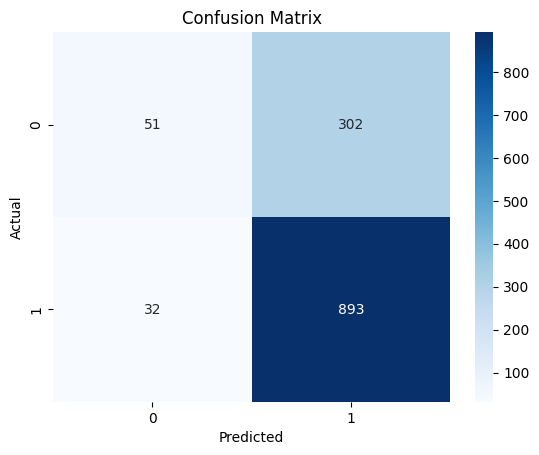

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [15]:
from sklearn.metrics import f1_score
F1_logistic = f1_score(y_test, preds)
F1_logistic

0.8424528301886792

In [20]:
(y_train==1).sum()/len(y_train)

0.760894716544543

In [31]:
from sklearn.ensemble import RandomForestClassifier
regr = RandomForestClassifier(max_depth=60
                              ,min_samples_split=4,  random_state=0)
regr.fit(X_train, y_train)
rand_pred = pd.DataFrame(regr.predict(X_test), columns = ["label"])
rand_pred_tr = pd.DataFrame(regr.predict(X_train), columns = ["label"])

In [32]:
rand_pred

,label
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
1273,1.0
1274,1.0
1275,1.0
1276,1.0


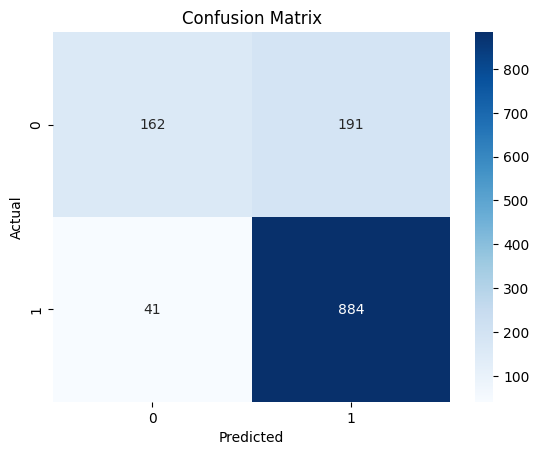

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, rand_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [34]:
from sklearn.metrics import f1_score
F1_logistic = f1_score(y_test, rand_pred)
F1_logistic

0.8839999999999999

In [35]:
rand_pred_tr

,label
0,1.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
2588,1.0
2589,1.0
2590,1.0
2591,0.0


In [36]:
rand_pred_All = pd.DataFrame(pd.concat([rand_pred,rand_pred_tr], axis = 0))

rand_pred_All.columns = ["predictions"]

In [37]:
rand_pred_All = (rand_pred_All.reset_index()).drop(columns = "index")

In [38]:
rand_pred_All = pd.concat([all_df["answer"], rand_pred_All], axis = 1)

In [39]:
rand_pred_All


,answer,predictions
0,Touch,1.0
1,Server,0.0
2,Lane,1.0
3,Beer,0.0
4,Island,0.0
...,...,...
3866,Flush,1.0
3867,Bandy,1.0
3868,House,1.0
3869,Clean,0.0


Text(0.5, 0, 'Relative Importance')

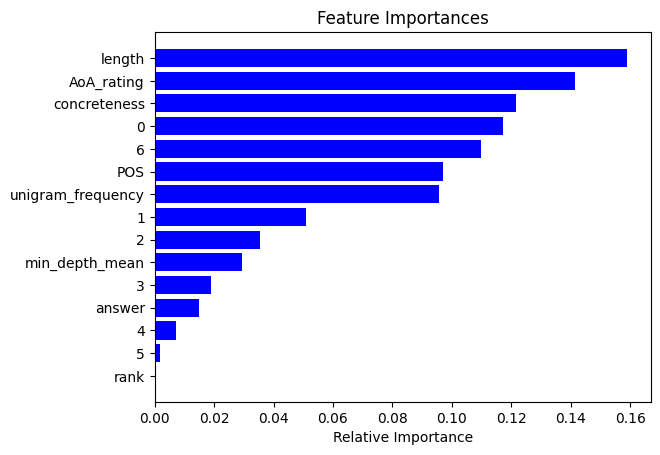

In [27]:
importances = regr.feature_importances_
indices = np.argsort(importances)
features = all_df.drop(columns = ["label"]).columns
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [28]:
all_df_w_pred = pd.concat([all_df, rand_pred_All["predictions"]], axis = 1)

In [29]:
all_df_w_pred.to_csv("/content/drive/MyDrive/EEE_486/Code/prediction_and_labels.csv")

In [92]:
import seaborn as sns

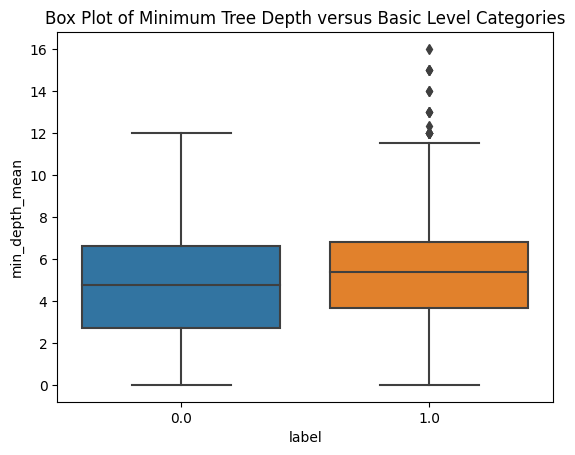

In [93]:
sns.boxplot(x='label', y='min_depth_mean', data=all_df[["min_depth_mean","label"]])
plt.title("Box Plot of Minimum Tree Depth versus Basic Level Categories")
plt.show()

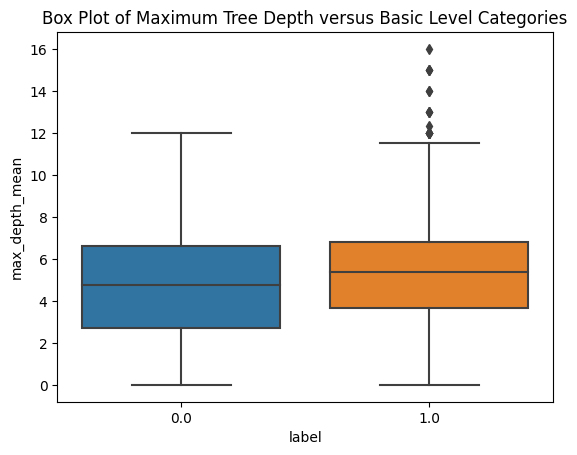

In [94]:
sns.boxplot(x='label', y='max_depth_mean', data=all_df[["max_depth_mean","label"]])

plt.title("Box Plot of Maximum Tree Depth versus Basic Level Categories")
plt.show()

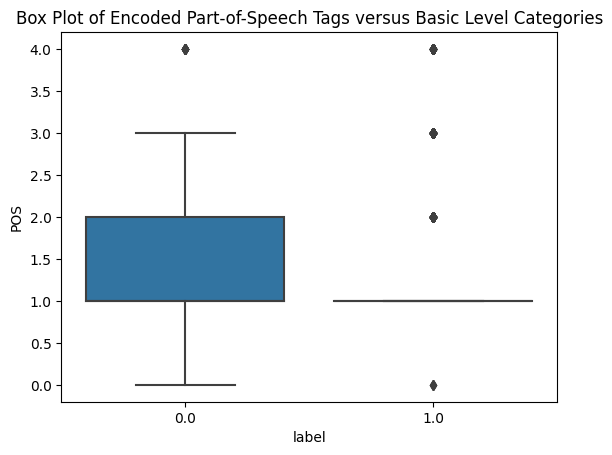

In [95]:
sns.boxplot(x='label', y='POS', data=all_df[["POS","label"]])

plt.title("Box Plot of Encoded Part-of-Speech Tags versus Basic Level Categories")
plt.show()

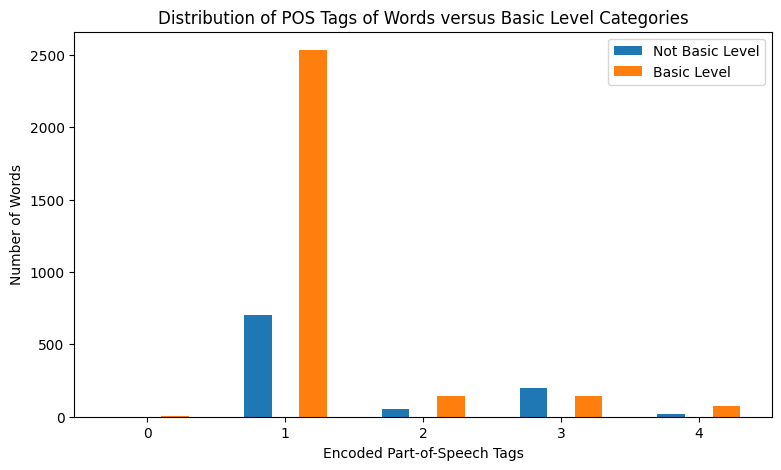

In [72]:
df_grouped0 =  pd.DataFrame(all_df[(all_df["label"]==0)][["POS","label"]].groupby(by ="POS", group_keys=True).apply(lambda x: len(x)))
df_grouped1 = pd.DataFrame( all_df[(all_df["label"]==1)][["POS","label"]].groupby(by = "POS", group_keys=True).apply(lambda x: len(x)))
df_grouped0.columns = ["Count of Basic Level Category"]       
df_grouped1.columns = ["Count of Basic Level Category"]       
x = ["NOUN", "ADJ", "VERB", "ADV", "ADJ_SAT"]

plt.figure(figsize=(9,5))
plt.bar(np.arange(0,5)-0.2, df_grouped0.values.reshape(-1), 0.2,label="Not Basic Level")
plt.bar(np.arange(0,5)+0.2, df_grouped1.values.reshape(-1),0.2,label="Basic Level")
plt.title("Distribution of POS Tags of Words versus Basic Level Categories")
# Display the plot
plt.legend()
plt.xlabel("Encoded Part-of-Speech Tags")
plt.ylabel("Number of Words")
plt.show()


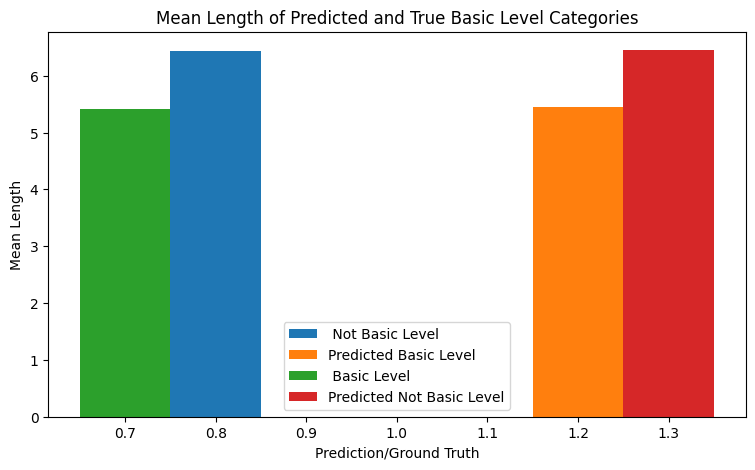

In [46]:
df_grouped0 =  pd.DataFrame(all_df_w_pred[(all_df_w_pred["label"]==0)][["length","label"]].groupby(by ="label", group_keys=True)["length"].mean())
df_grouped01 =  pd.DataFrame(all_df_w_pred[(all_df_w_pred["label"]==1)][["length","label"]].groupby(by ="label", group_keys=True)["length"].mean())

df_grouped1 = pd.DataFrame( all_df_w_pred[(all_df_w_pred["label"]==1)][["length","predictions"]].groupby(by = "predictions", group_keys=True)["length"].mean())
df_grouped11 = pd.DataFrame( all_df_w_pred[(all_df_w_pred["label"]==0)][["length","predictions"]].groupby(by = "predictions", group_keys=True)["length"].mean())

df_grouped0.columns = ["Count of Basic Level Category"]       
df_grouped1.columns = ["Count of Basic Level Category"]       

plt.figure(figsize=(9,5))
plt.bar(np.arange(1,2)-0.2, df_grouped0.values.reshape(-1), 0.1,label=" Not Basic Level")
plt.bar(np.arange(1,2)+0.2, df_grouped1.values.reshape(-1),0.1,label="Predicted Basic Level")
plt.bar(np.arange(1,2)-0.3, df_grouped01.values.reshape(-1), 0.1,label=" Basic Level")
plt.bar(np.arange(1,2)+0.3, df_grouped11.values.reshape(-1),0.1,label="Predicted Not Basic Level")
plt.title("Mean Length of Predicted and True Basic Level Categories")
# Display the plot
plt.legend()
plt.xlabel("Prediction/Ground Truth")
plt.ylabel("Mean Length")
plt.show()


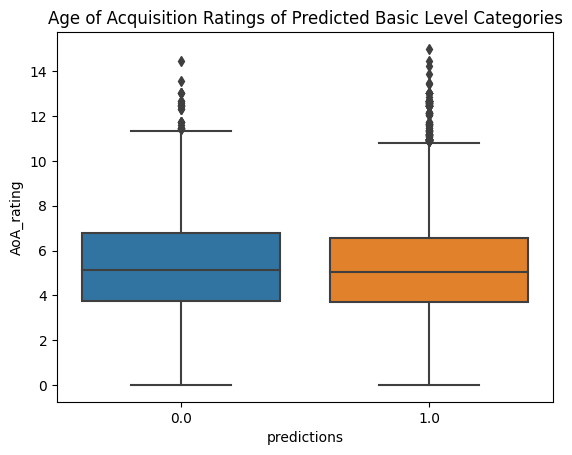

In [56]:
sns.boxplot(x='predictions', y='AoA_rating', data=all_df_w_pred[["AoA_rating","predictions"]])

plt.title("Age of Acquisition Ratings of Predicted Basic Level Categories")
plt.show()

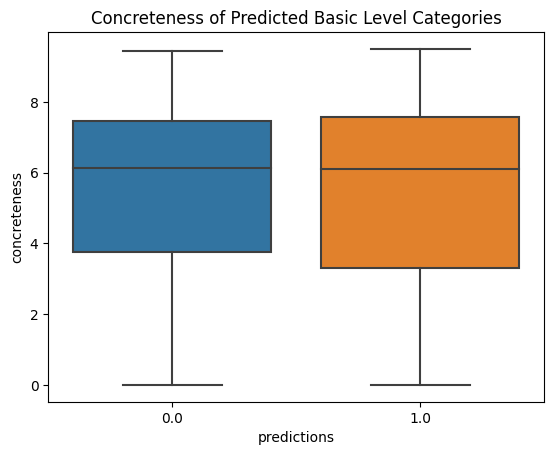

In [57]:
sns.boxplot(x='predictions', y='concreteness', data=all_df_w_pred[["concreteness","predictions"]])

plt.title("Concreteness of Predicted Basic Level Categories")
plt.show()

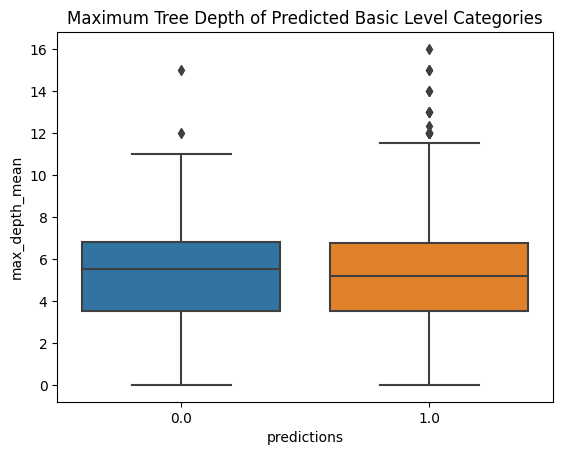

In [59]:
sns.boxplot(x='predictions', y='max_depth_mean', data=all_df_w_pred[["max_depth_mean","predictions"]])

plt.title("Maximum Tree Depth of Predicted Basic Level Categories")
plt.show()

In [73]:
(y_train==1).sum(),(y_train==0).sum()

(1973, 620)

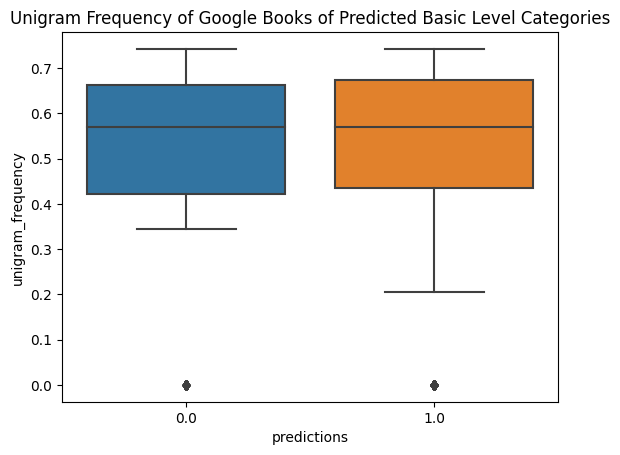

In [61]:
sns.boxplot(x='predictions', y='unigram_frequency', data=all_df_w_pred[["unigram_frequency","predictions"]])

plt.title("Unigram Frequency of Google Books of Predicted Basic Level Categories")
plt.show()

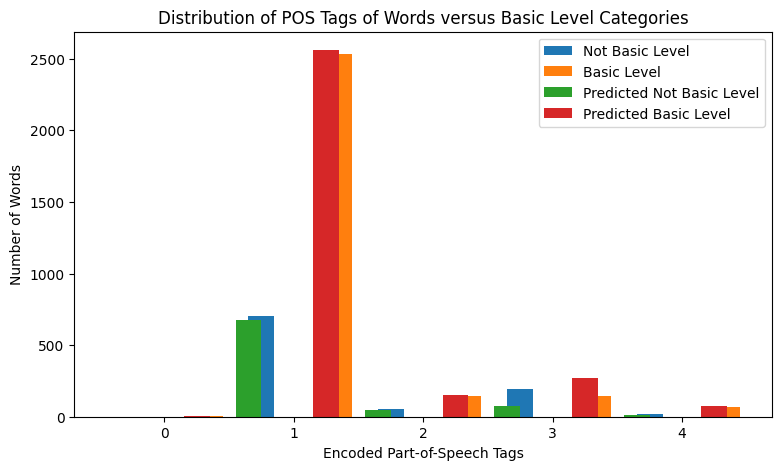

In [98]:
df_grouped0 =  pd.DataFrame(all_df_w_pred[(all_df_w_pred["predictions"]==0)][["POS","predictions"]].groupby(by ="POS", group_keys=True).apply(lambda x: len(x)))
df_grouped1 = pd.DataFrame( all_df_w_pred[(all_df_w_pred["predictions"]==1)][["POS","predictions"]].groupby(by = "POS", group_keys=True).apply(lambda x: len(x)))
df_grouped0.columns = ["Count of Basic Level Category"]       
df_grouped1.columns = ["Count of Basic Level Category"]       
df_grouped01 =  pd.DataFrame(all_df[(all_df["label"]==0)][["POS","label"]].groupby(by ="POS", group_keys=True).apply(lambda x: len(x)))
df_grouped11 = pd.DataFrame( all_df[(all_df["label"]==1)][["POS","label"]].groupby(by = "POS", group_keys=True).apply(lambda x: len(x)))
df_grouped0.columns = ["Count of Basic Level Category"]       
df_grouped1.columns = ["Count of Basic Level Category"]       

plt.figure(figsize=(9,5))
plt.bar(np.arange(0,5)-0.25, df_grouped01.values.reshape(-1), 0.2,label="Not Basic Level")
plt.bar(np.arange(0,5)+0.35, df_grouped11.values.reshape(-1),0.2,label="Basic Level")
plt.bar(np.arange(0,5)-0.35, df_grouped0.values.reshape(-1), 0.2,label="Predicted Not Basic Level")
plt.bar(np.arange(0,5)+0.25, df_grouped1.values.reshape(-1),0.2,label="Predicted Basic Level")
plt.title("Distribution of POS Tags of Words versus Basic Level Categories")
# Display the plot
plt.legend()
plt.xlabel("Encoded Part-of-Speech Tags")
plt.ylabel("Number of Words")
plt.show()


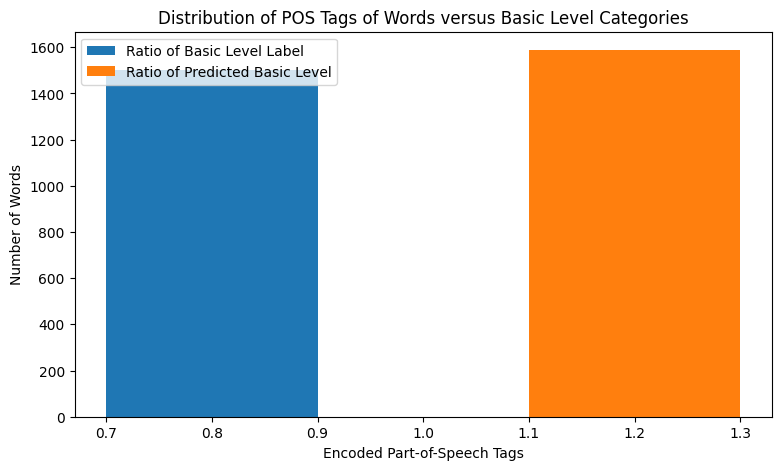

In [41]:
labels_grouped = pd.DataFrame(all_df_w_pred[["label","rank"]][all_df_w_pred["label"]==1].groupby(by = "rank", group_keys=True).apply(lambda x: len(x)))
preds_grouped = pd.DataFrame(all_df_w_pred[["predictions","rank"]][all_df_w_pred["predictions"]==1].groupby(by = "rank", group_keys=True).apply(lambda x: len(x)))
plt.figure(figsize=(9,5))
plt.bar(np.arange(1,2)-0.2, labels_grouped.values.reshape(-1), 0.2,label="Ratio of Basic Level Label")
plt.bar(np.arange(1,2)+0.2, preds_grouped.values.reshape(-1),0.2,label="Ratio of Predicted Basic Level")
plt.title("Distribution of POS Tags of Words versus Basic Level Categories")
# Display the plot
plt.legend()
plt.xlabel("Encoded Part-of-Speech Tags")
plt.ylabel("Number of Words")
plt.show()


In [43]:
all_df_w_pred["rank"]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3866    3.0
3867    3.0
3868    3.0
3869    3.0
3870    3.0
Name: rank, Length: 3871, dtype: float64